First of all we will do a model exploration in a base case (no policies implemented); <br/>
Next we will do a model exploration with random policies; <br/>
after a sensitivity and vulnerability analysis will be done; <br/>
at last a Optimization will be run to find optimal solutions. <br/>

# 1. Model exploration

In [1]:
# initialize for this run
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario
from ema_workbench import Model, RealParameter, ScalarOutcome, CategoricalParameter, IntegerParameter, BooleanParameter, Policy
from SALib.analyze import sobol

from ema_workbench.analysis import prim
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import dimensional_stacking
from ema_workbench import (MultiprocessingEvaluator, SequentialEvaluator)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import GenerationalBorg

from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.em_framework.evaluators import BaseEvaluator

from dike_model_function import DikeNetwork

from ProblemFormulationSelf import problem_definition

from ema_workbench import save_results
from ema_workbench.util.utilities import load_results

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### optimization

### MOEA for our dike rings

In [2]:
model, planning_steps = problem_definition('A4, A5 vars')

In [3]:
reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'discount rate': 3.5,
                        'ID flood wave shape': 4}
scen1 = {}

for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name[:-2]]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario('reference', **scen1)

convergence_metrics = [EpsilonProgress()]
epsilon = [0.05,] * len(model.outcomes)
nfe=100000

In [4]:
with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=ref_scenario
                                              )

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/100000 nfe
Process ForkPoolWorker-29:
Process ForkPoolWorker-13:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Process ForkPoolWorker-28:
Process ForkPoolWorker-10:
Process ForkPoolWorker-25:
Process ForkPoolWorker-31:
Process ForkPoolWorker-11:
Process ForkPoolWorker-5:
Process ForkPoolWorker-20:
Process ForkPoolWorker-18:
Process ForkPoolWorker-30:
Process ForkPoolWorker-27:
Process ForkPoolWorker-9:
Process ForkPoolWorker-1:
Process ForkPoolWorker-24:
Process ForkPoolWorker-2:
Process ForkPoolWorker-12:
Process ForkPoolWorker-8:
Process ForkPoolWorker-21:
Process ForkPoolWorker-26:
Process ForkPoolWorker-23:
Process ForkPoolWorker-14:
Process ForkPoolWorker-22:
Process ForkPoolWorker-15:


KeyboardInterrupt: 

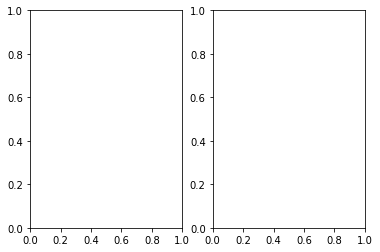

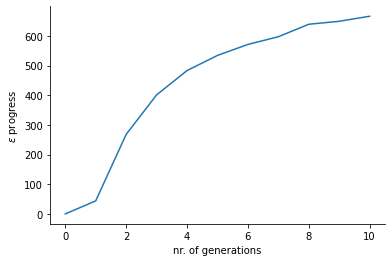

In [13]:
## epsilon 0.5 9 solutions with 10000 nfe
fig, ax1 = plt.subplots(ncols=2, sharex=True)
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

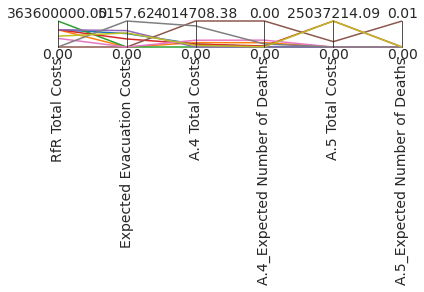

In [17]:
# print(results)
outcomes = results.loc[:, ['RfR Total Costs', 'Expected Evacuation Costs', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('max_P') 
plt.show()

In [9]:
nfe = 10000
epsilon = [0.025,] * len(model.outcomes)
with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=ref_scenario
                                              )

[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] generation 10: 995/10000 nfe
[MainProcess/INFO] generation 15: 1493/10000 nfe
[MainProcess/INFO] generation 20: 1992/10000 nfe
[MainProcess/INFO] generation 25: 2490/10000 nfe
[MainProcess/INFO] generation 30: 2986/10000 nfe
[MainProcess/INFO] generation 35: 3486/10000 nfe
[MainProcess/INFO] generation 40: 3986/10000 nfe
[MainProcess/INFO] generation 45: 4485/10000 nfe
[MainProcess/INFO] generation 50: 4984/10000 nfe
[MainProcess/INFO] generation 55: 5482/10000 nfe
[MainProcess/INFO] generation 60: 5978/10000 nfe
[MainProcess/INFO] generation 65: 6472/10000 nfe
[MainProcess/INFO] generation 70: 6969/10000 nfe
[MainProcess/INFO] generation 75: 7468/10000 nfe
[MainProcess/INFO] generation 80: 7966/10000 nfe
[MainProcess/INFO] generation 85: 8463/10000 nfe
[MainProcess/INFO] generation 90: 8957/10000 nfe
[MainProcess/INFO] generation 95: 9456/10000 nfe
[MainProcess/INFO] generati

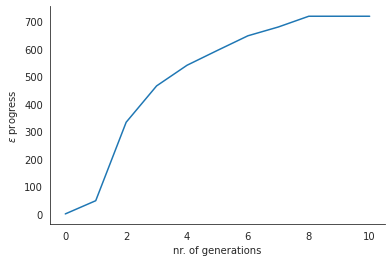

In [10]:
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

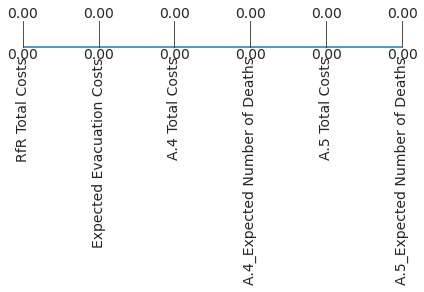

In [11]:
outcomes = results.loc[:, ['RfR Total Costs', 'Expected Evacuation Costs', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('max_P') 
plt.show()

In [5]:
nfe = 10000
epsilon = [0.1,] * len(model.outcomes)
with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=ref_scenario
                                              )

[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] generation 10: 997/10000 nfe
[MainProcess/INFO] generation 15: 1497/10000 nfe
[MainProcess/INFO] generation 20: 1993/10000 nfe
[MainProcess/INFO] generation 25: 2493/10000 nfe
[MainProcess/INFO] generation 30: 2988/10000 nfe
[MainProcess/INFO] generation 35: 3487/10000 nfe
[MainProcess/INFO] generation 40: 3986/10000 nfe
[MainProcess/INFO] generation 45: 4486/10000 nfe
[MainProcess/INFO] generation 50: 4986/10000 nfe
[MainProcess/INFO] generation 55: 5486/10000 nfe
[MainProcess/INFO] generation 60: 5983/10000 nfe
[MainProcess/INFO] generation 65: 6483/10000 nfe
[MainProcess/INFO] generation 70: 6981/10000 nfe
[MainProcess/INFO] generation 75: 7479/10000 nfe
[MainProcess/INFO] generation 80: 7976/10000 nfe
[MainProcess/INFO] generation 85: 8471/10000 nfe
[MainProcess/INFO] generation 90: 8969/10000 nfe
[MainProcess/INFO] generation 95: 9469/10000 nfe
[MainProcess/INFO] generati

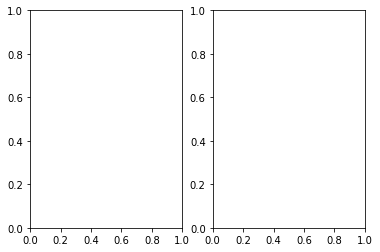

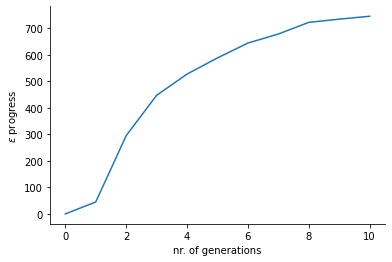

In [7]:
fig, ax1 = plt.subplots(ncols=2, sharex=True)
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

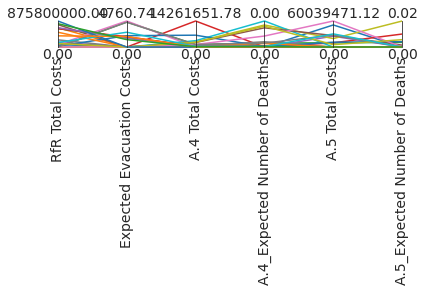

In [8]:
# print(results)
outcomes = results.loc[:, ['RfR Total Costs', 'Expected Evacuation Costs', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('max_P') 
plt.show()

In [19]:
nfe = 100000
epsilon = [0.05,] * len(model.outcomes)
with MultiprocessingEvaluator(model) as evaluator:
    total = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=ref_scenario)
results, convergence = total
save_results(total, './data/exp/MOEA100k.tar.gz')

[MainProcess/INFO] generation 0: 0/100000 nfe
[MainProcess/INFO] generation 5: 499/100000 nfe
[MainProcess/INFO] generation 10: 995/100000 nfe
[MainProcess/INFO] generation 15: 1493/100000 nfe
[MainProcess/INFO] generation 20: 1990/100000 nfe
[MainProcess/INFO] generation 25: 2487/100000 nfe
[MainProcess/INFO] generation 30: 2985/100000 nfe
[MainProcess/INFO] generation 35: 3480/100000 nfe
[MainProcess/INFO] generation 40: 3966/100000 nfe
[MainProcess/INFO] generation 45: 4461/100000 nfe
[MainProcess/INFO] generation 50: 4954/100000 nfe
[MainProcess/INFO] generation 55: 5445/100000 nfe
[MainProcess/INFO] generation 60: 5929/100000 nfe
[MainProcess/INFO] generation 65: 6388/100000 nfe
[MainProcess/INFO] generation 70: 6837/100000 nfe
[MainProcess/INFO] generation 75: 7292/100000 nfe
[MainProcess/INFO] generation 80: 7762/100000 nfe
[MainProcess/INFO] generation 85: 8226/100000 nfe
[MainProcess/INFO] generation 90: 8708/100000 nfe
[MainProcess/INFO] generation 95: 9181/100000 nfe
[MainPr

In [ ]:
save_results(total, './data/exp/MOEA100k.tar.gz')

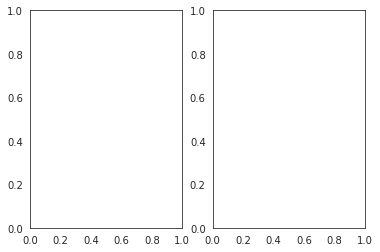

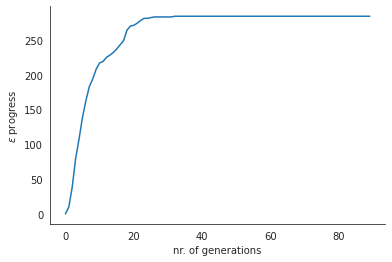

In [20]:
fig, ax1 = plt.subplots(ncols=2, sharex=True)
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

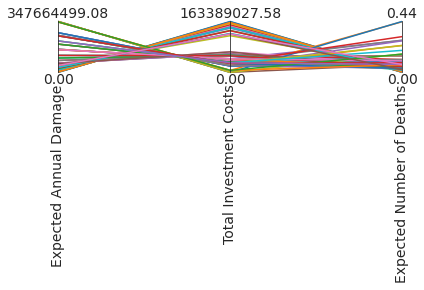

In [24]:
# print(results)
outcomes = results.loc[:, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)


plt.show()

### MOEA for all

In [2]:
model, planning_steps = problem_definition('damage, cost, deaths')

In [3]:
nfe=10000

reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'discount rate': 3.5,
                        'ID flood wave shape': 4}
scen1 = {}

for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name[:-2]]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario('reference', **scen1)

convergence_metrics = [EpsilonProgress()]
epsilon = [0.05,] * len(model.outcomes)

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=ref_scenario
                                              )

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] generation 10: 1000/10000 nfe
[MainProcess/INFO] generation 15: 1499/10000 nfe
[MainProcess/INFO] generation 20: 1998/10000 nfe
[MainProcess/INFO] generation 25: 2497/10000 nfe
[MainProcess/INFO] generation 30: 2996/10000 nfe
[MainProcess/INFO] generation 35: 3493/10000 nfe
[MainProcess/INFO] generation 40: 3984/10000 nfe
[MainProcess/INFO] generation 45: 4478/10000 nfe
[MainProcess/INFO] generation 50: 4969/10000 nfe
[MainProcess/INFO] generation 55: 5462/10000 nfe
[MainProcess/INFO] generation 60: 5953/10000 nfe
[MainProcess/INFO] generation 65: 6438/10000 nfe
[MainProcess/INFO] generation 70: 6911/10000 nfe
[MainProcess/INFO] generation 75: 7383/10000 nfe
[MainProcess/INFO] generation 80: 7858/10000 nfe
[MainProcess/INFO] generation 85: 8338/10000 nfe
[MainProcess/INFO] generation 90: 8822/10000 nfe
[MainProcess/INFO] generation 95: 9310/1000

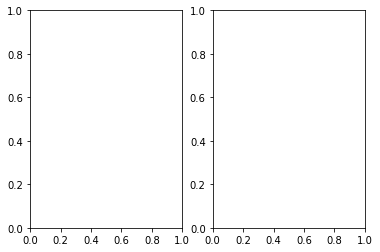

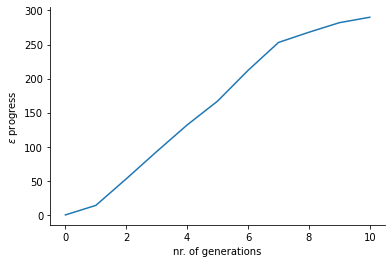

In [4]:
## epsilon 0.5 9 solutions with 10000 nfe
fig, ax1 = plt.subplots(ncols=2, sharex=True)
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()

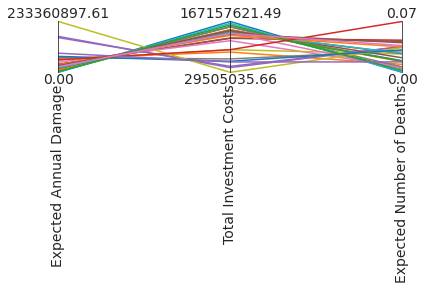

In [6]:
# print(results)
outcomes = results.loc[:, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)


plt.show()

### MORDM

### mordm for A4 and A5

In [ ]:
model, planning_steps = problem_definition('A4, A5 vars')

### mordm for all

In [ ]:
model, planning_steps = problem_definition('damage, cost, deaths')

### MORO

In [13]:
model, planning_steps = problem_definition('damage, cost, deaths')

In [25]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 0.000001) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 100000) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Total_Investment_Costs = functools.partial(robustness, SMALLER, 150000000)#THOSE NUMBERS NEED TO BE SPECIFIED AGAINS

robustness_funcs = {"Expected Number of Deaths": Expected_Number_of_Deaths,
                    "Expected Annual Damage": Expected_Annual_Damage,
                    "Total Investment Costs": Total_Investment_Costs}

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('fraction EA deaths', kind=MINIMIZE, 
                             variable_name='Expected Number of Deaths', function=Expected_Number_of_Deaths),
                       ScalarOutcome('fraction EA damage', kind=MINIMIZE, 
                             variable_name='Expected Annual Damage', function=Expected_Annual_Damage)]

n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)

In [26]:
nfe = 1000
BaseEvaluator.reporting_frequency = 0.1
convergence = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 1.1]),
              EpsilonProgress()]

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(model) as evaluator:
    total = evaluator.robust_optimize(robustnes_functions, scenarios,nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons)
archive, convergence = total

[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 498/1000 nfe
[MainProcess/INFO] generation 10: 997/1000 nfe
[MainProcess/INFO] optimization completed, found 1 solutions


In [27]:
save_results(total, './data/exp/moro1k_NoCostLimit.tar.gz')

[MainProcess/INFO] results saved successfully to /home/jovyan/work/final assignment/data/exp/moro1k_NoCostLimit.tar.gz
